In [1]:
import pandas as pd
import requests
import pdfplumber
import re
import numpy as np
# import gspread
import csv
import time
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


# Import your pdf

This is my own path, you'd need to specifiy your personal path

In [2]:
### windows version
# pdf = pdfplumber.open(r"C:\Users\james\Dropbox\bosStatementExtraction_ghp\jpy_statement1.pdf")

### mac version
pdf = pdfplumber.open("/Users/james.koh/Dropbox/current projects/youtrip statement extraction/jpy_statement2.pdf")
page = pdf.pages[1]

# Find the raw bottom coordinates for fields of interest and hard code them as explicit
##### Since the "auto" detection of the horizontal rows are delinated by purple backgrounds that are inconsistent, we need to manually find bottom coordinates of each row to plot lines explicitly

In [3]:
### your regex
end_of_row = [page.search(r'¥\d{1,3}(?:,\d{3})*')]
first_line_after_header = [page.search(r'\bBalance\b')]
# end_of_row_2 = [page.search(r'$|\d')]

### (optional) crop the page using the top and bottom coordinates
# cropped_page = page.crop((451.59, 306.83000000000004, 482.15999999999997, 316.83000000000004))
# im = cropped_page.to_image()
# im

# Page-by-page debugging

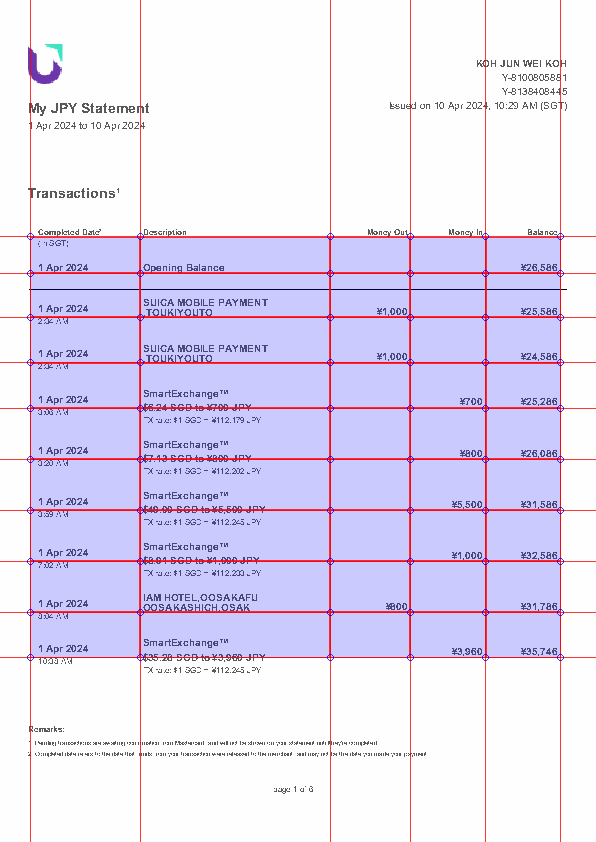

In [4]:
### quick override of the above declaration of "page" for ez debugging
### this sample only extracts one page at a time. You may choose to put this block in a loop to extract multiple pages.
page = pdf.pages[0]

row_bottom_coordinates_list = []

### we use the final jpy value at the end of each row of the "balance" column as some type of explicit delineation for horizonal line
end_of_row = [page.search(r'¥\d{1,3}(?:,\d{3})*')]

for i in range(50):
    
    try:
        # fix the issue of regex picking up values from "smartexchange" transactions and creating unneccesary lines
        # this 556.96 is the end of right hand column
        if end_of_row[0][i]['x1'] == 556.96 or 556.9599999999999:
            # print(end_of_row_1[0][i]['text']) # for testing
            row_bottom_coordinates = end_of_row[0][i]['bottom']
            row_bottom_coordinates_list.append(row_bottom_coordinates)

    except IndexError:
        
        break

### remove duplicated fields due to same regex identified values occuring more than once in a "row"
row_bottom_coordinates_list = list(dict.fromkeys(row_bottom_coordinates_list))

### insert a horizontal line after the header, specifically after the word "Balance"
row_bottom_coordinates_list.insert(0,first_line_after_header[0][0]['bottom'])

im = page.to_image()

im.reset().debug_tablefinder({
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "explicit",
    "explicit_horizontal_lines": row_bottom_coordinates_list,
    "explicit_vertical_lines": [ 30, 140, 330, 410, 485,560],
})

As you can see from the above, it's not a perfect solution. Some transaction descriptions are cut off halfway due to the statement's inconsistent spacing. Nevertheless, the key details - such as the date, balance, money in, money out and little bits of the description are still good enough.

In [5]:
all_transactions = []

page_transactions = page.extract_table({
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "explicit",
    "explicit_horizontal_lines": row_bottom_coordinates_list,
    "explicit_vertical_lines": [ 30, 140, 330, 410, 485,560],
})

for row in page_transactions:
    all_transactions.append(row)

# Fit the data into a dataframe

In [6]:
df_transactions = pd.DataFrame(all_transactions, columns=['date', 'description', 'money out', 'money in', 'balance'])
df_transactions

,date,description,money out,money in,balance
0,(in SGT)\n1 Apr 2024,Opening Balance,,,"¥26,586"
1,1 Apr 2024,"SUICA MOBILE PAYMENT\n,TOUKIYOUTO","¥1,000",,"¥25,586"
2,2:34 AM\n1 Apr 2024,"SUICA MOBILE PAYMENT\n,TOUKIYOUTO","¥1,000",,"¥24,586"
3,2:34 AM\n1 Apr 2024,SmartExchange™,,¥700,"¥25,286"
4,3:06 AM\n1 Apr 2024,$6.24 SGD to ¥700 JPY\nFX rate: $1 SGD = ¥112....,,¥800,"¥26,086"
5,3:20 AM\n1 Apr 2024,$7.13 SGD to ¥800 JPY\nFX rate: $1 SGD = ¥112....,,"¥5,500","¥31,586"
6,3:59 AM\n1 Apr 2024,"$49.00 SGD to ¥5,500 JPY\nFX rate: $1 SGD = ¥1...",,"¥1,000","¥32,586"
7,7:02 AM\n1 Apr 2024,"$8.91 SGD to ¥1,000 JPY\nFX rate: $1 SGD = ¥11...",¥800,,"¥31,786"
8,8:04 AM\n1 Apr 2024,SmartExchange™,,"¥3,960","¥35,746"


# Clean the data 

In [7]:
# Apply a custom function to split the string only if it contains '\n'
def split_string(cell):
    if '\n' in cell:
        return cell.split('\n')[1]
    else:
        return cell


df_transactions['date'] = df_transactions['date'].apply(split_string)
df_transactions['description'] = df_transactions['description'].apply(split_string)
df_transactions['money out'] = df_transactions['money out'].apply(split_string)
df_transactions['money in'] = df_transactions['money in'].apply(split_string)
df_transactions['balance'] = df_transactions['balance'].apply(split_string)

df_transactions

,date,description,money out,money in,balance
0,1 Apr 2024,Opening Balance,,,"¥26,586"
1,1 Apr 2024,",TOUKIYOUTO","¥1,000",,"¥25,586"
2,1 Apr 2024,",TOUKIYOUTO","¥1,000",,"¥24,586"
3,1 Apr 2024,SmartExchange™,,¥700,"¥25,286"
4,1 Apr 2024,FX rate: $1 SGD = ¥112.179 JPY,,¥800,"¥26,086"
5,1 Apr 2024,FX rate: $1 SGD = ¥112.202 JPY,,"¥5,500","¥31,586"
6,1 Apr 2024,FX rate: $1 SGD = ¥112.245 JPY,,"¥1,000","¥32,586"
7,1 Apr 2024,FX rate: $1 SGD = ¥112.233 JPY,¥800,,"¥31,786"
8,1 Apr 2024,SmartExchange™,,"¥3,960","¥35,746"


# Export as CSV

In [8]:
df_transactions.to_csv('youtrip_jpy_txn_2.csv', index=False)
print("CSV file has been exported successfully.")

CSV file has been exported successfully.
